In [290]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [291]:
# kaggle competition https://www.kaggle.com/c/nlp-getting-started

In [292]:
# we will take train dataset from Kaggle and split it into train/ test (we cannot use test dataset from Kaggle
# since it has no labels)
all_data = pd.read_csv("../train.csv")

In [293]:
all_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [294]:
all_data.shape

(7613, 5)

In [295]:
all_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [296]:
all_data = all_data.fillna("")

In [297]:
# let's append keyword and lockation to the text:

def concat(a, b, c):
    return a + " " + b + " " + c

all_data['full_text'] = all_data.apply(lambda x: concat(x['keyword'], x['location'], x['text']), axis=1)

In [298]:
# random shift
all_data = all_data.sample(frac=1)

In [299]:
all_data.head()

,id,keyword,location,text,target,full_text
3605,5146,fatal,,Tell me why or why not\nto adopt in this way\n...,0,fatal Tell me why or why not\nto adopt in thi...
3034,4355,earthquake,oklahoma,Posted a new song: 'Earthquake' http://t.co/Rf...,0,earthquake oklahoma Posted a new song: 'Earthq...
7479,10698,wreck,United States,@_PokemonCards_ @IceQueenFroslas why did they ...,0,wreck United States @_PokemonCards_ @IceQueenF...
6834,9788,trapped,å_å_Los Mina Cityã¢,Hollywood Movie About Trapped Miners Released ...,0,trapped å_å_Los Mina Cityã¢ Hollywood Movie A...
6193,8840,sirens,"Ventura, Ca",Kyle is one of the last people I would expect ...,0,"sirens Ventura, Ca Kyle is one of the last peo..."


In [300]:
# this function was taken from https://www.kaggle.com/adinishad/nlp-80-accuracy
def clean_data(my_text):
    # Replace email addresses with 'email'
    processed = my_text.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                     'emailaddress')

    # Replace URLs with 'webaddress'
    processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                      'webaddress')

    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
    processed = processed.str.replace(r'£|\$', 'moneysymb')

    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                      'phonenumbr')

    # Replace numbers with 'numbr'
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

    # Remove punctuation
    processed = processed.str.replace(r'[^\w\d\s]', ' ')

    # Replace whitespace between terms with a single space
    processed = processed.str.replace(r'\s+', ' ')

    # Remove leading and trailing whitespace
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    # change words to lower case - Hello, HELLO, hello are all the same word
    processed = processed.str.lower()
    
    # remove stop words
    stop_words = set(stopwords.words("english"))
    processed = processed.apply(lambda x:" ".join(term for term in word_tokenize(x) if term not in stop_words))
    
    # stemming
    ps = PorterStemmer()
    processed = processed.apply(lambda x:" ".join([ps.stem(word) for word in x.split()]))
    
    # lemmatization
    wl = WordNetLemmatizer()
    processed = processed.apply(lambda x:" ".join([wl.lemmatize(word) for word in x.split()]))
    
    
    return processed

In [301]:
all_data_clean = clean_data(all_data["full_text"])

In [302]:
all_data["full_text"][0]

'  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [303]:
all_data_clean[0]

'deed reason earthquak may allah forgiv u'

In [304]:
all_data["clean_text"] = all_data_clean

In [305]:
all_data.to_csv("tweets_data.csv")

In [86]:
seed = 7

X = all_data.clean_text
y = all_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [87]:
x_train_row = X_train.copy()

In [89]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000) # limit number of features to avoid overfitting
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [90]:
X_train.shape

(6090, 1000)

In [91]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [92]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
X_train.max()

1.0

In [94]:
y_train = y_train.values
y_test = y_test.values

### k-means clustering and Expectation Maximization on row data

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import IncrementalPCA 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.decomposition import PCA

In [250]:
# we will use it for visualization in the first part
pca = PCA(n_components=2)
pca.fit(X_train)
transformed_data = pca.transform(X_train)



The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [63]:
sa = []

for n_clusters in range(2, 200):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    silhouette_avg = silhouette_score(X_train, cluster_labels)
    sa.append(silhouette_avg)
    

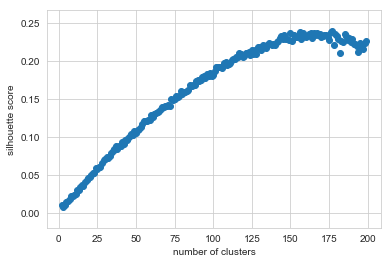

In [64]:
plt.scatter([item for item in range(2, 200)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

In [66]:
max(sa)

0.23971285815394394

In [67]:
sa.index(max(sa))

175

In [65]:
for i in range(2, 200):
    print("For n_clusters =", i, "The average silhouette_score is :", sa[i-2])

For n_clusters = 2 The average silhouette_score is : 0.011198276486327971
For n_clusters = 3 The average silhouette_score is : 0.007637812386806975
For n_clusters = 4 The average silhouette_score is : 0.011207544978291104
For n_clusters = 5 The average silhouette_score is : 0.014232446713390658
For n_clusters = 6 The average silhouette_score is : 0.01667333876272828
For n_clusters = 7 The average silhouette_score is : 0.01805069267344972
For n_clusters = 8 The average silhouette_score is : 0.022185290116492933
For n_clusters = 9 The average silhouette_score is : 0.022181300965146526
For n_clusters = 10 The average silhouette_score is : 0.02396661310130431
For n_clusters = 11 The average silhouette_score is : 0.02509240615910063
For n_clusters = 12 The average silhouette_score is : 0.030725430599808878
For n_clusters = 13 The average silhouette_score is : 0.030504346981080975
For n_clusters = 14 The average silhouette_score is : 0.034848249286889885
For n_clusters = 15 The average silho

Text(0.5, 0.98, 'KMeans clustering with n_clusters = 150')

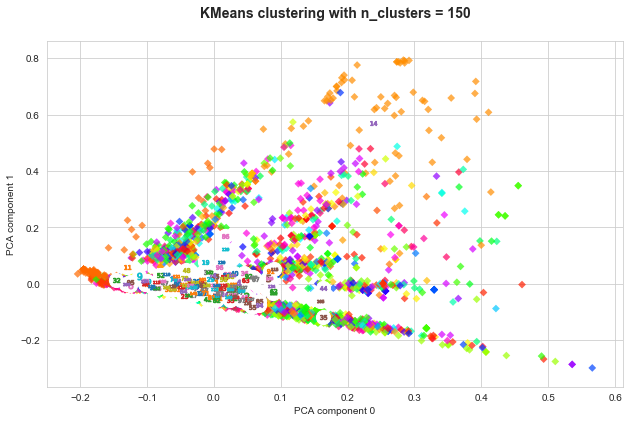

In [251]:
fig = plt.figure(figsize=(10,6))

# Add set of axes to figure
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=150, random_state=10)
cluster_labels = clusterer.fit_predict(X_train)

    
cmap = cm.get_cmap("hsv")
colors = cmap(cluster_labels.astype(float) / 150)
    
    
ax2.scatter(transformed_data[ : ,0],transformed_data[ : ,1], marker='D', s=30, lw=0, alpha=0.7,
                c=cluster_labels, cmap='hsv')

# Labeling the clusters
centers = pca.transform(clusterer.cluster_centers_)
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

ax2.set_xlabel("PCA component 0")
ax2.set_ylabel("PCA component 1")

plt.suptitle(("KMeans clustering with n_clusters = %d" % 150),
                 fontsize=14, fontweight='bold')

In [252]:
silhouette_avg = silhouette_score(X_train, cluster_labels)
silhouette_avg

0.22550773444021643

In [104]:
cl_size = []

for i in range(150):
    cl_size.append(len(x_train_row[cluster_labels==i]))

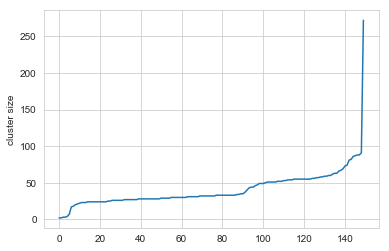

In [108]:
cl_size.sort()
plt.plot(cl_size)
plt.ylabel('cluster size');

In [111]:
x_train_row[cluster_labels==20].values

array(['first numbrrespond liberti township ohio red throw word hero around lightli usual reserv first respond militari hero',
       'first numbrrespond texa usatoday pray god heal safeti first respond',
       'first numbrrespond nashvil tennesse grate first respond mnpdnashvil nashvillefd other act swiftli save countless live today',
       'first numbrrespond aberdeenshir u want futur first respond high tech http co numbrvinumbrrnbknumbri',
       'first numbrrespond michigan kirsten gillibrand http co ameanumbrlamdj extend health care numbr first respond',
       'first numbrrespond franklin tn near nashvil shoot event theater starbuck give free coffe first respond polic amp firefight antiochhickoryhollow tn',
       'first numbrrespond worldwid love way book written includ mani vantag point first respond detkenlang kindl http co kcrnmjkjnumbr',
       'first numbrrespond hoop somewher inca accid first respond would know babi present http co snaymldiun',
       'first numbrrespond

In [112]:
x_train_row[cluster_labels==30].values

array(['crush everywher tiffanyfrizzel crush http co rafnumbrvrtt',
       'crush popey bout get crush',
       'crush crush gym crush butterfing flurri clearli prioriti straight',
       'crush washington dc nativ mrrobinson give thesteveharveyshow vibe music teacher look student crush girl went high school',
       'crush everywher samel_samel crush http co tbstknumbrvqunumbr',
       'crush lil brother crush mariah',
       'crush ayekoradio play brasswork agenc crush shaken http co qhnumbraxvhwhnumbr radio netlabel electronicmus listen ccmusic',
       'crush ina bute girl crush',
       'crush honeymoon avenu jaureguiswisdom lmao well know one ive crush one sooo',
       'crush chicago lake buena vista rememb nora jone crush two week notic',
       'crush numbr numbr numbr crush holi shit',
       'crush http co kgnumbrplkedhr wrapup numbr u cabl tv compani share crush disney disappoint http co qeihvnnumbrdnq',
       'crush love love playa crush lot', 'crush woman crush',
       

### Expectation Maximization on row data

In [116]:
sa = []
for n_clusters in range(2, 200):
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="spherical", random_state=10)
        cluster_labels = clusterer.fit_predict(X_train)

        silhouette_avg = silhouette_score(X_train, cluster_labels)
        sa.append(silhouette_avg)
    

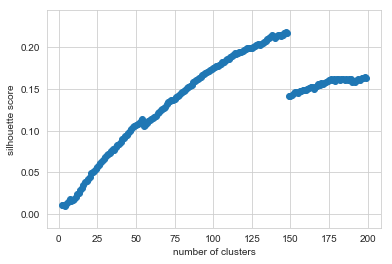

In [117]:
plt.scatter([item for item in range(2, 200)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

In [118]:
sa.index(max(sa))

145

In [119]:
sa[145]

0.21886574065094141

In [121]:
sa[146]

0.21753447700335465

147 clusters gives us the best score

Text(0.5, 0.98, 'Expectation Maximization clustering with n_clusters = 147')

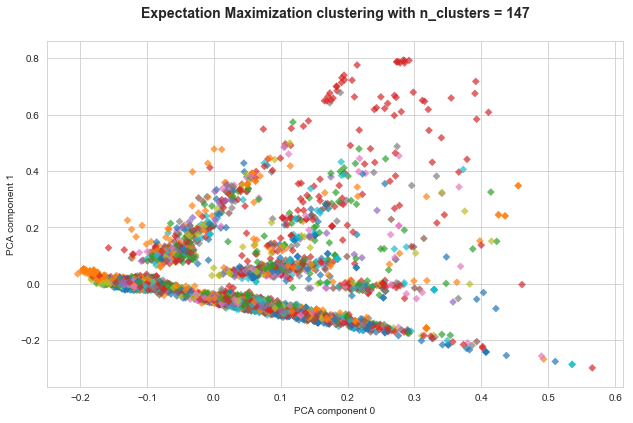

In [253]:
fig = plt.figure(figsize=(10,6))

# Add set of axes to figure
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = GaussianMixture(n_components=147, covariance_type='spherical', random_state=10)
cluster_labels = clusterer.fit_predict(X_train)


ax2.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,
                    c=cluster_labels, cmap='tab10',marker='D')
        
ax2.set_xlabel("PCA component 0")
ax2.set_ylabel("PCA component 1")

plt.suptitle(("Expectation Maximization clustering with n_clusters = %d" % 147),
                     fontsize=14, fontweight='bold')

In [254]:
silhouette_avg = silhouette_score(X_train, cluster_labels)
silhouette_avg

0.21886574065094141

In [123]:
x_train_row[cluster_labels==20].values

array(['collaps scotland would paramed realli leav someon insid build collaps blow halloikbenwil',
       'bridg numbrcollaps leed england listen blower tuffer aussi bat collaps trent bridg remind love bbctm wonder stuff engvau',
       'collaps runaway minion caus traffic collaps dublin http co unumbrkwofnumbrwtj',
       'collaps blackpool england uk ash numbr australia total collaps internet absolut love http co afzqvotutj',
       'collaps san francisco bay area quora answer answer get collaps other http co ikfmektpcx',
       'bridg numbrcollaps two giant crane hold bridg collaps nearbi home http co qnumbrqnumbrxnumbrvcqk',
       'collaps europ greec tax revenu collaps debt crisi continu via guardian bailout http co cjvbqxwnumbr mp',
       'collaps victoria british columbia collaps bed ugh exhaust',
       'collaps fakefam correct tent collaps stori http co snumbrvygenjuv',
       'bridg numbrcollaps mumbai ameenshaikhnumbr ur logic bridg didnt collaps second train engin cross b

In [124]:
x_train_row[cluster_labels==7].values

array(['obliter canada silverhuski shtap town obliter earth salt t_t',
       'obliter wynn ar rockbottomradfm kid rememb hear rule numbr numbr day wo defens strip brock obliter',
       'obliter none souda leav ladi sonia alon shall obliter kneelbot',
       'obliter win kerri numbr numbr obliter',
       'obliter seattl fun instagram http co mnumbrnjvvtygn jeb bush said earlier week want obliter plan parenthood bu û_',
       'obliter memespher accord propheci also cnn mac tablet complet obliter need gadget combin û_ http co xfccvmxuwb',
       'obliter numbr w patrick st frederick drunk meal numbr cook total obliter http co wjnumbrunumbrmppb',
       'obliter wood god met cocki right love urib obliter ball strut fuck batter box',
       'obliter god order obliter ancient canaanit http co pkkcdwjygnumbr via worldnetdaili',
       'obliter overton nv interest god order obliter ancient canaanit http co xqmjhiozxg via worldnetdaili',
       'obliter valparaiso rizzo ball obliter',
     

### PCA

In [238]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import kurtosis

In [277]:
pca = PCA(random_state=0)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'PCA explained variance vs number of components')

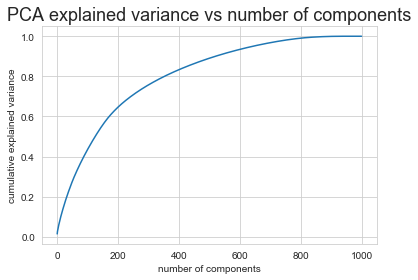

In [278]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("PCA explained variance vs number of components", fontsize=18)

In [279]:
pca.explained_variance_ratio_[0]

0.014544090102490054

In [280]:
pca.n_components_

1000

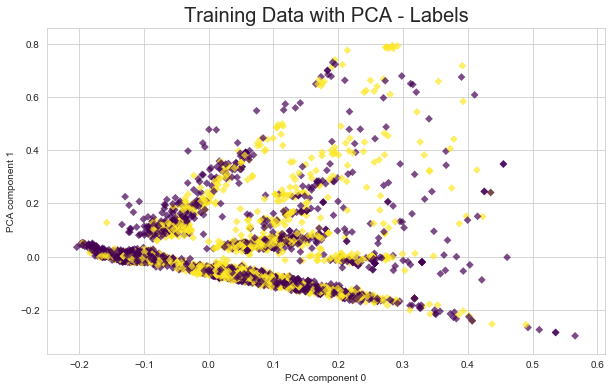

In [281]:
transformed_data = pca.transform(X_train)

fig, axes = plt.subplots(figsize=(10,6))
classes = [0,1]
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=y_train, cmap='viridis', marker="D")


plt.title('Training Data with PCA - Labels', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')
plt.show()

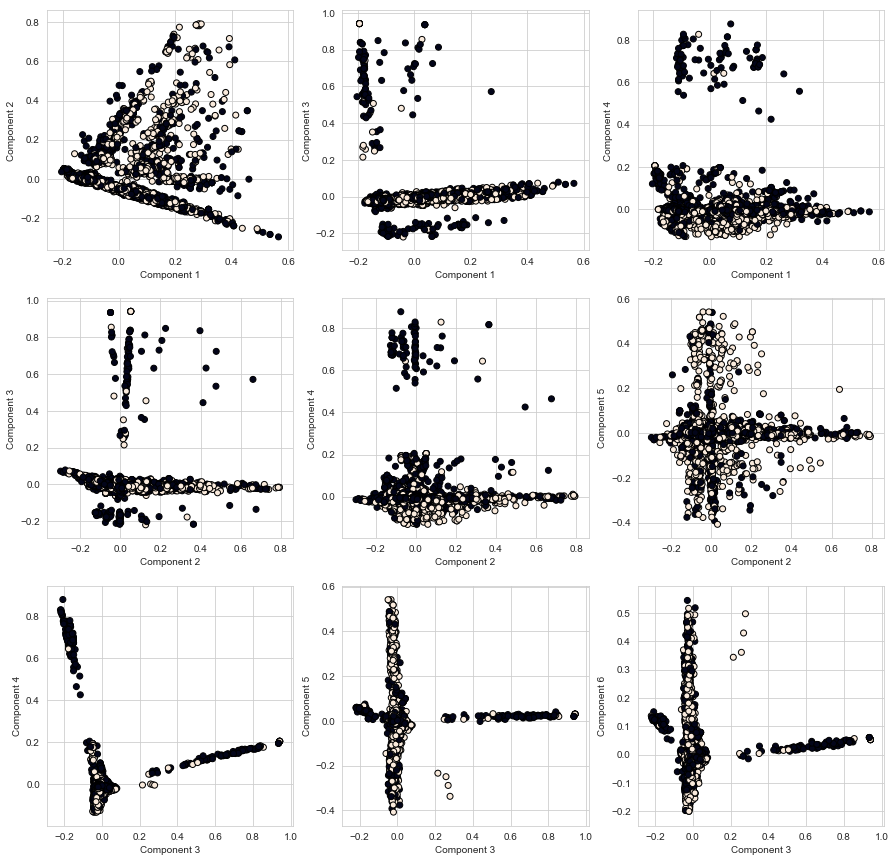

In [196]:
td = pca.transform(X_train)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0, 0].scatter(td[:,0],td[:,1],c=y_train,edgecolor='k')
axs[0, 1].scatter(td[:,0],td[:,2],c=y_train,edgecolor='k')
axs[0, 2].scatter(td[:,0],td[:,3],c=y_train,edgecolor='k')
axs[1, 0].scatter(td[:,1],td[:,2],c=y_train,edgecolor='k')
axs[1, 1].scatter(td[:,1],td[:,3],c=y_train,edgecolor='k')
axs[1, 2].scatter(td[:,1],td[:,4],c=y_train,edgecolor='k')
axs[2, 0].scatter(td[:,2],td[:,3],c=y_train,edgecolor='k')
axs[2, 1].scatter(td[:,2],td[:,4],c=y_train,edgecolor='k')
axs[2, 2].scatter(td[:,2],td[:,5],c=y_train,edgecolor='k')
axs[0, 0].set_ylabel('Component 2')
axs[0, 0].set_xlabel('Component 1')
axs[0, 1].set_ylabel('Component 3')
axs[0, 1].set_xlabel('Component 1')
axs[0, 2].set_ylabel('Component 4')
axs[0, 2].set_xlabel('Component 1')

axs[1, 0].set_ylabel('Component 3')
axs[1, 0].set_xlabel('Component 2')
axs[1, 1].set_ylabel('Component 4')
axs[1, 1].set_xlabel('Component 2')
axs[1, 2].set_ylabel('Component 5')
axs[1, 2].set_xlabel('Component 2')

axs[2, 0].set_ylabel('Component 4')
axs[2, 0].set_xlabel('Component 3')
axs[2, 1].set_ylabel('Component 5')
axs[2, 1].set_xlabel('Component 3')
axs[2, 2].set_ylabel('Component 6')
axs[2, 2].set_xlabel('Component 3')

plt.show()


#### Clustering on PCA applyed data

In [282]:
# we will use only first 800 components since they explain more than 90% of variance
pca = PCA(random_state=0)
pca.fit(X_train)
td = pca.transform(X_train)
td_600 = td[:, :600]

In [284]:
# kmean
sa = []

for n_clusters in range(2, 200, 20):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(td_600)

    silhouette_avg = silhouette_score(td_600, cluster_labels)
    sa.append(silhouette_avg)

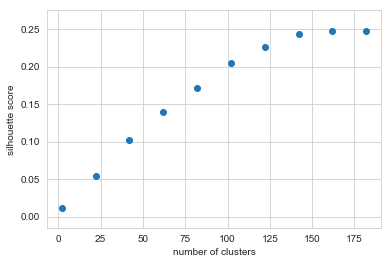

In [285]:
plt.scatter([item for item in range(2, 200, 20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

In [286]:
clusterer = KMeans(n_clusters=140, random_state=10)
cluster_labels = clusterer.fit_predict(td_600)

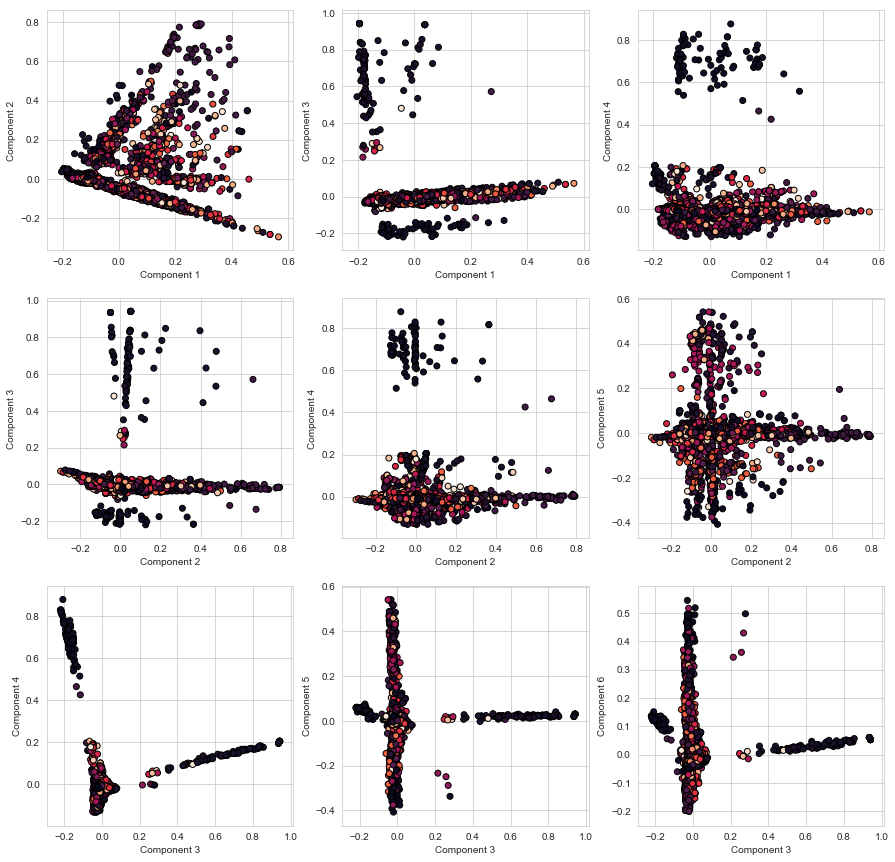

In [287]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0, 0].scatter(td[:,0],td[:,1],c=cluster_labels,edgecolor='k')
axs[0, 1].scatter(td[:,0],td[:,2],c=cluster_labels,edgecolor='k')
axs[0, 2].scatter(td[:,0],td[:,3],c=cluster_labels,edgecolor='k')
axs[1, 0].scatter(td[:,1],td[:,2],c=cluster_labels,edgecolor='k')
axs[1, 1].scatter(td[:,1],td[:,3],c=cluster_labels,edgecolor='k')
axs[1, 2].scatter(td[:,1],td[:,4],c=cluster_labels,edgecolor='k')
axs[2, 0].scatter(td[:,2],td[:,3],c=cluster_labels,edgecolor='k')
axs[2, 1].scatter(td[:,2],td[:,4],c=cluster_labels,edgecolor='k')
axs[2, 2].scatter(td[:,2],td[:,5],c=cluster_labels,edgecolor='k')
axs[0, 0].set_ylabel('Component 2')
axs[0, 0].set_xlabel('Component 1')
axs[0, 1].set_ylabel('Component 3')
axs[0, 1].set_xlabel('Component 1')
axs[0, 2].set_ylabel('Component 4')
axs[0, 2].set_xlabel('Component 1')

axs[1, 0].set_ylabel('Component 3')
axs[1, 0].set_xlabel('Component 2')
axs[1, 1].set_ylabel('Component 4')
axs[1, 1].set_xlabel('Component 2')
axs[1, 2].set_ylabel('Component 5')
axs[1, 2].set_xlabel('Component 2')

axs[2, 0].set_ylabel('Component 4')
axs[2, 0].set_xlabel('Component 3')
axs[2, 1].set_ylabel('Component 5')
axs[2, 1].set_xlabel('Component 3')
axs[2, 2].set_ylabel('Component 6')
axs[2, 2].set_xlabel('Component 3')

plt.show()

In [288]:
silhouette_avg = silhouette_score(td_800, cluster_labels)
silhouette_avg

0.22793447583165616

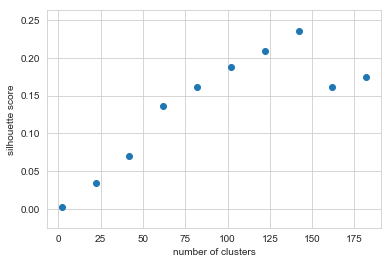

In [289]:
# Expectation Maximization
sa = []
for n_clusters in range(2, 200, 20):
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="spherical", random_state=10)
        cluster_labels = clusterer.fit_predict(td_600)

        silhouette_avg = silhouette_score(td_600, cluster_labels)
        sa.append(silhouette_avg)

plt.scatter([item for item in range(2, 200, 20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');


In [257]:
clusterer = GaussianMixture(n_components=160, covariance_type="spherical", random_state=10)
cluster_labels = clusterer.fit_predict(td_800)

silhouette_avg = silhouette_score(td_800, cluster_labels)
silhouette_avg

0.22590472895731378

### ICA

Text(0, 0.5, 'ICA component 1')

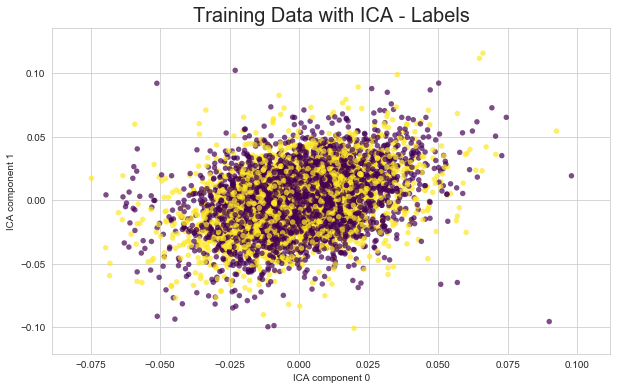

In [162]:
ica = FastICA(random_state=0,  tol=1.0, max_iter=10000)
ica.fit(X_train)
transformed_data = ica.transform(X_train)

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=y_train, cmap= 'viridis')

plt.title('Training Data with ICA - Labels', fontsize=20)
plt.xlabel('ICA component 0')
plt.ylabel('ICA component 1')

Thus, the absolute value of the kurtosis can be used as a measure of nonGaussianity
Look at average kurtosis while varying number of components. We discussed how to interpret kurtosis in a previous live session but you should understand what kurtosis says about your distribution... and then use that knowledge to choose the number of components.

Text(0.5, 1.0, 'ICA Kurtosis for Tweet dataset')

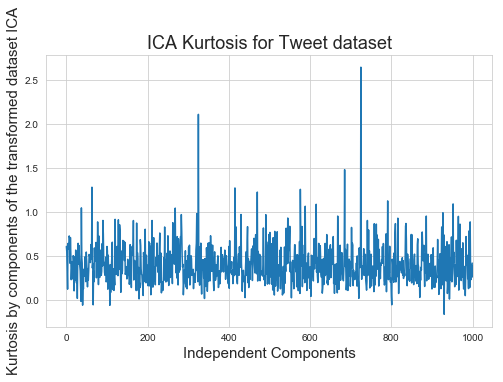

In [163]:
kurt = kurtosis(transformed_data,fisher=True)
plt.figure(figsize=(8,5))
plt.plot(kurt)
plt.xlabel("Independent Components",fontsize=15)
plt.ylabel("Kurtosis by components of the transformed dataset ICA",fontsize=15)
plt.title("ICA Kurtosis for Tweet dataset", fontsize=18)

In [164]:
kurt.mean()

0.40331388937539686

In [165]:
krs = []
for i in [5,6,7,8,9,10,11,12,13,14, 15, 25, 50, 100, 200, 400, 800,1000]:
    ica = FastICA(random_state=0,n_components=i,  tol=1.0, max_iter=10000)
    ica.fit(X_train)
    td = ica.transform(X_train)
    kurt = kurtosis(td,fisher=True)
    print("number of components: ", i, "average kurtosis: ", kurt.mean())
    krs.append(kurt.mean())

number of components:  5 average kurtosis:  16.25492880996977
number of components:  6 average kurtosis:  18.90333757810458
number of components:  7 average kurtosis:  22.57529439171198
number of components:  8 average kurtosis:  12.469381965399885
number of components:  9 average kurtosis:  13.671400945292483
number of components:  10 average kurtosis:  18.610777335567914
number of components:  11 average kurtosis:  12.128320952029474
number of components:  12 average kurtosis:  13.03227326239435
number of components:  13 average kurtosis:  11.483320091071887
number of components:  14 average kurtosis:  11.297138147419222
number of components:  15 average kurtosis:  11.678136051076972
number of components:  25 average kurtosis:  9.806293625726537
number of components:  50 average kurtosis:  9.24607142632643
number of components:  100 average kurtosis:  7.549224629763126
number of components:  200 average kurtosis:  5.325749143994492
number of components:  400 average kurtosis:  2.3268

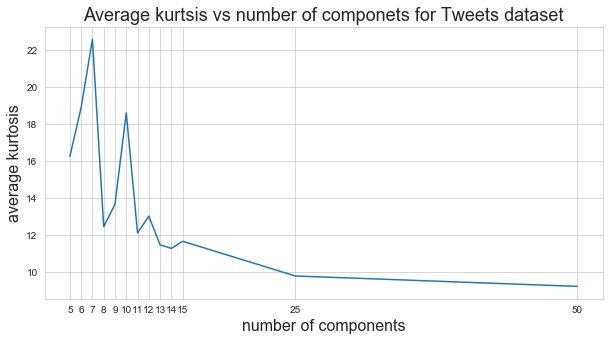

In [176]:
plt.figure(figsize=(10,5))
plt.plot([item for item in [5,6,7,8,9,10,11,12,13,14, 15, 25, 50]], krs[:13],'-')
plt.xlabel('number of components',fontsize=16)
plt.ylabel('average kurtosis',fontsize=16)
plt.xticks([5,6,7,8,9,10,11,12,13,14, 15, 25, 50],fontsize=10)
plt.title("Average kurtsis vs number of componets for Tweets dataset",fontsize=18);

In [177]:
ica = FastICA(random_state=0,n_components=7,  tol=1.0, max_iter=10000)
ica.fit(X_train)
td = ica.transform(X_train)

In [178]:
td.shape

(6090, 7)

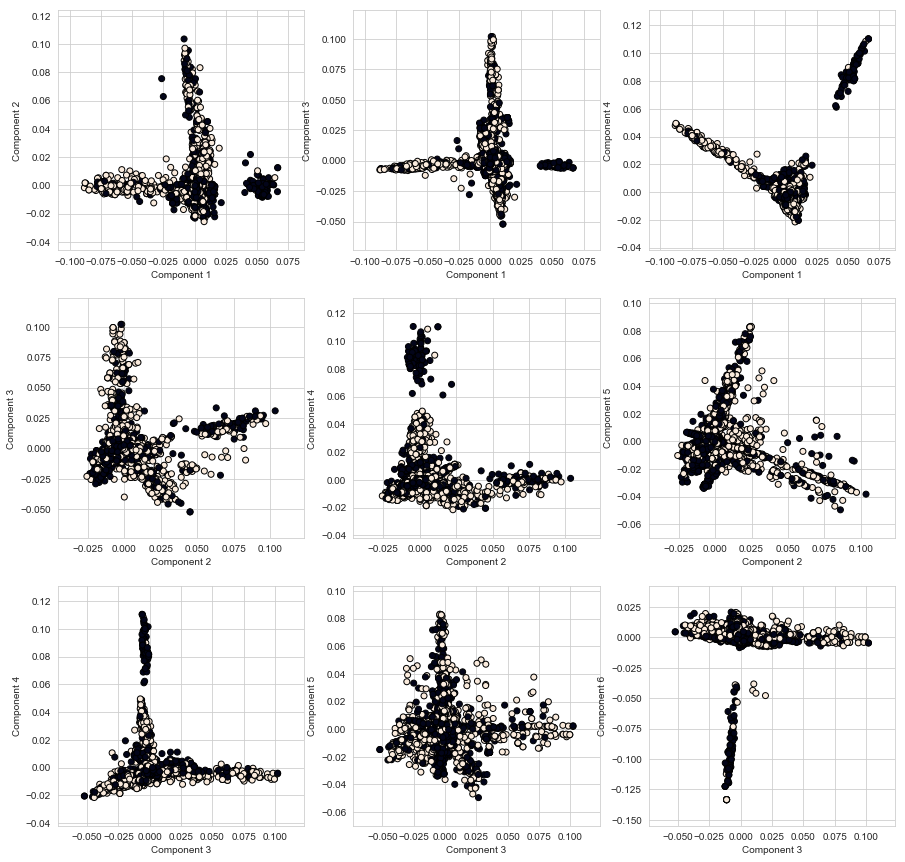

In [191]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0, 0].scatter(td[:,0],td[:,1],c=y_train,edgecolor='k')
axs[0, 1].scatter(td[:,0],td[:,2],c=y_train,edgecolor='k')
axs[0, 2].scatter(td[:,0],td[:,3],c=y_train,edgecolor='k')
axs[1, 0].scatter(td[:,1],td[:,2],c=y_train,edgecolor='k')
axs[1, 1].scatter(td[:,1],td[:,3],c=y_train,edgecolor='k')
axs[1, 2].scatter(td[:,1],td[:,4],c=y_train,edgecolor='k')
axs[2, 0].scatter(td[:,2],td[:,3],c=y_train,edgecolor='k')
axs[2, 1].scatter(td[:,2],td[:,4],c=y_train,edgecolor='k')
axs[2, 2].scatter(td[:,2],td[:,5],c=y_train,edgecolor='k')
axs[0, 0].set_ylabel('Component 2')
axs[0, 0].set_xlabel('Component 1')
axs[0, 1].set_ylabel('Component 3')
axs[0, 1].set_xlabel('Component 1')
axs[0, 2].set_ylabel('Component 4')
axs[0, 2].set_xlabel('Component 1')

axs[1, 0].set_ylabel('Component 3')
axs[1, 0].set_xlabel('Component 2')
axs[1, 1].set_ylabel('Component 4')
axs[1, 1].set_xlabel('Component 2')
axs[1, 2].set_ylabel('Component 5')
axs[1, 2].set_xlabel('Component 2')

axs[2, 0].set_ylabel('Component 4')
axs[2, 0].set_xlabel('Component 3')
axs[2, 1].set_ylabel('Component 5')
axs[2, 1].set_xlabel('Component 3')
axs[2, 2].set_ylabel('Component 6')
axs[2, 2].set_xlabel('Component 3')

plt.show()

#### clustering on ICA data

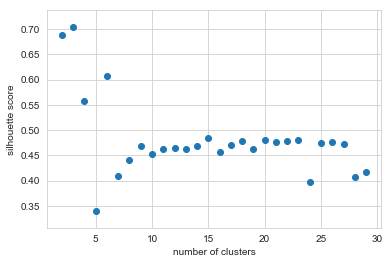

In [260]:
ica = FastICA(random_state=0,n_components=7,  tol=1.0, max_iter=10000)
ica.fit(X_train)
td = ica.transform(X_train)

# kmean
sa = []

for n_clusters in range(2, 30):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(td)

    silhouette_avg = silhouette_score(td, cluster_labels)
    sa.append(silhouette_avg)
    
plt.scatter([item for item in range(2, 30)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');    
    

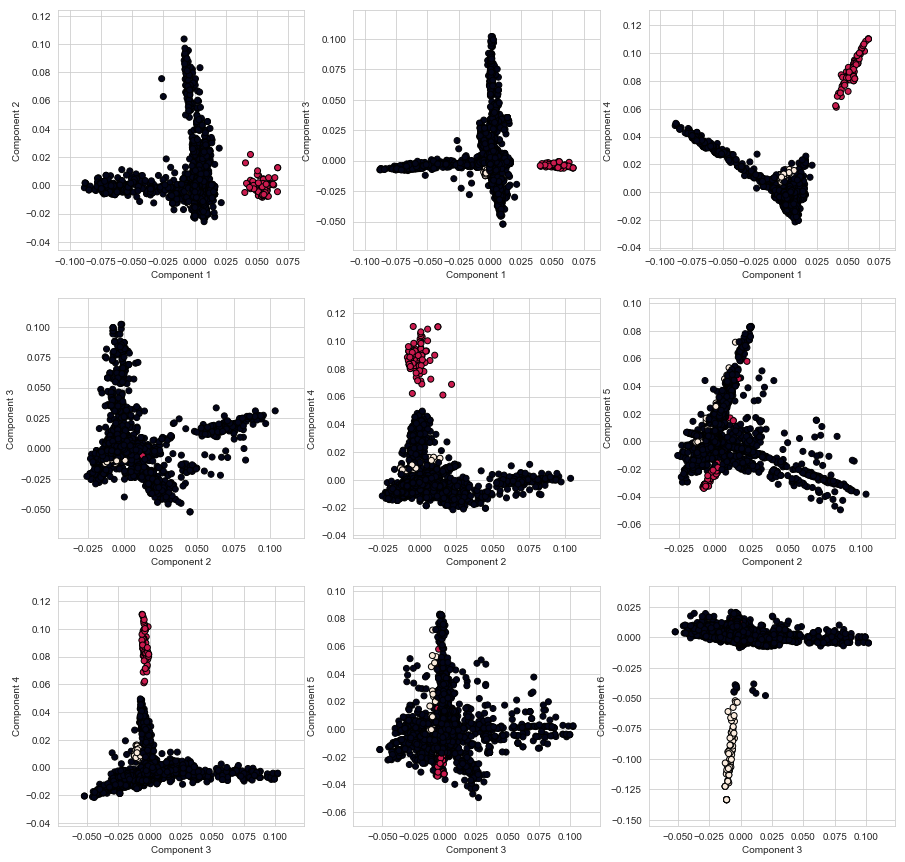

In [261]:
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(td)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0, 0].scatter(td[:,0],td[:,1],c=cluster_labels,edgecolor='k')
axs[0, 1].scatter(td[:,0],td[:,2],c=cluster_labels,edgecolor='k')
axs[0, 2].scatter(td[:,0],td[:,3],c=cluster_labels,edgecolor='k')
axs[1, 0].scatter(td[:,1],td[:,2],c=cluster_labels,edgecolor='k')
axs[1, 1].scatter(td[:,1],td[:,3],c=cluster_labels,edgecolor='k')
axs[1, 2].scatter(td[:,1],td[:,4],c=cluster_labels,edgecolor='k')
axs[2, 0].scatter(td[:,2],td[:,3],c=cluster_labels,edgecolor='k')
axs[2, 1].scatter(td[:,2],td[:,4],c=cluster_labels,edgecolor='k')
axs[2, 2].scatter(td[:,2],td[:,5],c=cluster_labels,edgecolor='k')
axs[0, 0].set_ylabel('Component 2')
axs[0, 0].set_xlabel('Component 1')
axs[0, 1].set_ylabel('Component 3')
axs[0, 1].set_xlabel('Component 1')
axs[0, 2].set_ylabel('Component 4')
axs[0, 2].set_xlabel('Component 1')

axs[1, 0].set_ylabel('Component 3')
axs[1, 0].set_xlabel('Component 2')
axs[1, 1].set_ylabel('Component 4')
axs[1, 1].set_xlabel('Component 2')
axs[1, 2].set_ylabel('Component 5')
axs[1, 2].set_xlabel('Component 2')

axs[2, 0].set_ylabel('Component 4')
axs[2, 0].set_xlabel('Component 3')
axs[2, 1].set_ylabel('Component 5')
axs[2, 1].set_xlabel('Component 3')
axs[2, 2].set_ylabel('Component 6')
axs[2, 2].set_xlabel('Component 3')

plt.show()

In [262]:
silhouette_avg = silhouette_score(td, cluster_labels)
silhouette_avg

0.7039056195421282

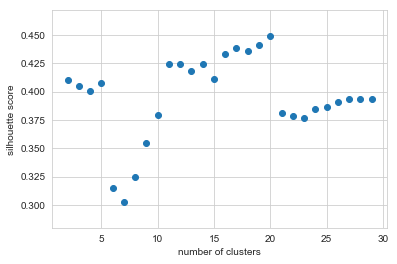

In [263]:
# Expectation Maximization
sa = []
for n_clusters in range(2, 30):
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="spherical", random_state=10)
        cluster_labels = clusterer.fit_predict(td)

        silhouette_avg = silhouette_score(td, cluster_labels)
        sa.append(silhouette_avg)

plt.scatter([item for item in range(2, 30)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');



In [264]:
clusterer = GaussianMixture(n_components=20, covariance_type="spherical", random_state=10)
cluster_labels = clusterer.fit_predict(td)

silhouette_avg = silhouette_score(td, cluster_labels)
silhouette_avg

0.44927397019338167

#### Randomized Projections

In [215]:
from sklearn.random_projection import SparseRandomProjection
from scipy.linalg import pinv

In [276]:
def recError(prs,row_data):
    w = prs.components_.todense()
    p = pinv(w)
    reconstructed = ((p@w)@(row_data.T)).T 
    errors = np.square(row_data-reconstructed)
    return np.nanmean(errors)

In [209]:
srp = SparseRandomProjection(random_state=0, eps=0.3)
transformed_data = srp.fit_transform(X_train)

In [210]:
transformed_data.shape

(6090, 968)

In [223]:
err_by_n_comp = []
for i in range(5,1000,25):
    srp = SparseRandomProjection(random_state=0, n_components=i)
    srp.fit(X_train)  
    err_by_n_comp.append((i,recError(srp, X_train)))

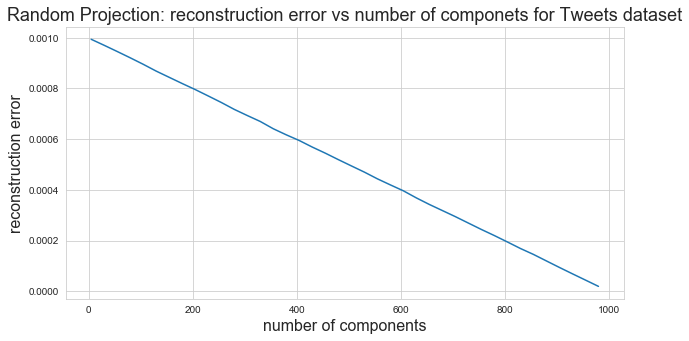

In [227]:
plt.figure(figsize=(10,5))
plt.plot([i[0] for i in err_by_n_comp],[i[1] for i in err_by_n_comp],'-')
plt.xlabel('number of components',fontsize=16)
plt.ylabel('reconstruction error',fontsize=16)
#plt.xticks([i[0] for i in err_by_n_comp],fontsize=10)
plt.title("Random Projection: reconstruction error vs number of componets for Tweets dataset",fontsize=18);

#### Clustering on Randomized Projection

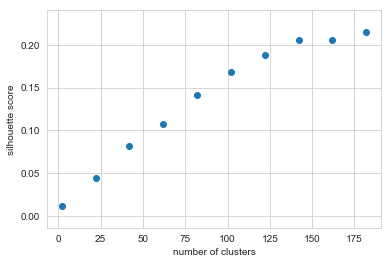

In [265]:
srp = SparseRandomProjection(random_state=0, eps=0.3)
transformed_data = srp.fit_transform(X_train)


# kmean
sa = []

for n_clusters in range(2, 200, 20):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(transformed_data)

    silhouette_avg = silhouette_score(transformed_data, cluster_labels)
    sa.append(silhouette_avg)
    
plt.scatter([item for item in range(2, 200, 20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');  

In [266]:
transformed_data.shape

(6090, 968)

In [267]:
clusterer = KMeans(n_clusters=140, random_state=10)
cluster_labels = clusterer.fit_predict(transformed_data)

silhouette_avg = silhouette_score(transformed_data, cluster_labels)
silhouette_avg

0.2057624296073573

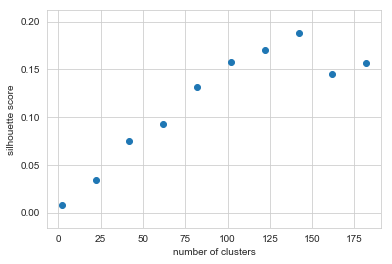

In [268]:
# Expectation Maximization
sa = []
for n_clusters in range(2, 200,20):
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="spherical", random_state=10)
        cluster_labels = clusterer.fit_predict(transformed_data)

        silhouette_avg = silhouette_score(transformed_data, cluster_labels)
        sa.append(silhouette_avg)

plt.scatter([item for item in range(2, 200,20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

In [269]:
clusterer = GaussianMixture(n_components=140, covariance_type="spherical", random_state=10)
cluster_labels = clusterer.fit_predict(transformed_data)

silhouette_avg = silhouette_score(transformed_data, cluster_labels)
silhouette_avg

0.18573227756110497

#### Any other feature selection algorithm you desire (L1-based feature selection)

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [231]:
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0]

for c in C:
    m = LogisticRegression(random_state=0, C=c) 
    scores = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy')
    print("c: ", c, " accuracy: ", np.median(scores))

c:  0.0001  accuracy:  0.5697865353037767
c:  0.001  accuracy:  0.5697865353037767
c:  0.01  accuracy:  0.5697865353037767
c:  0.1  accuracy:  0.7602627257799671
c:  1.0  accuracy:  0.7848932676518884
c:  5.0  accuracy:  0.7865353037766831


In [237]:
m = LogisticRegression(random_state=0, C=0.1).fit(X_train, y_train)
model = SelectFromModel(m, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(6090, 364)

In [235]:
m = LogisticRegression(random_state=0, C=1.0).fit(X_train, y_train)
model = SelectFromModel(m, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(6090, 417)

In [236]:
m = LogisticRegression(random_state=0, C=5.0).fit(X_train, y_train)
model = SelectFromModel(m, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(6090, 429)

#### Clustering on L1 redused data

(6090, 417)


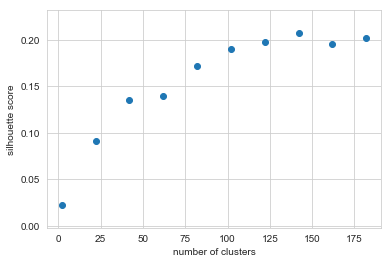

In [270]:
m = LogisticRegression(random_state=0, C=1.0).fit(X_train, y_train)
model = SelectFromModel(m, prefit=True)
X_new = model.transform(X_train)
print(X_new.shape)


# kmean
sa = []

for n_clusters in range(2, 200, 20):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_new)

    silhouette_avg = silhouette_score(X_new, cluster_labels)
    sa.append(silhouette_avg)
    
plt.scatter([item for item in range(2, 200, 20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');  

In [271]:
clusterer = KMeans(n_clusters=140, random_state=10)
cluster_labels = clusterer.fit_predict(X_new)

silhouette_avg = silhouette_score(X_new, cluster_labels)
silhouette_avg

0.2068222264012825

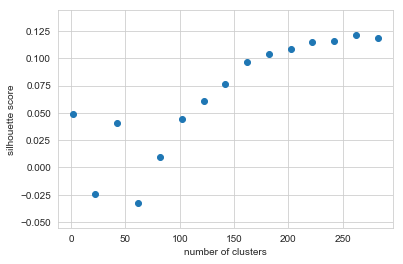

In [273]:
# Expectation Maximization
sa = []
for n_clusters in range(2, 300,20):
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="spherical", random_state=10)
        cluster_labels = clusterer.fit_predict(X_new)

        silhouette_avg = silhouette_score(X_new, cluster_labels)
        sa.append(silhouette_avg)

plt.scatter([item for item in range(2, 300,20)], sa)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

In [274]:
clusterer = KMeans(n_clusters=260, random_state=10)
cluster_labels = clusterer.fit_predict(X_new)

silhouette_avg = silhouette_score(X_new, cluster_labels)
silhouette_avg

0.18301237310002505